# **Grab Safety Telematics Dataset**
*   The telematics data collected during driving trips are useful to detect if the trip is dangerous and has high crash / accident probability.

# **Problem Statements**
*   Which feature has a high impact on indicating dangerous trips?
*   How does the driving behaviour change over time (second) for normal trips and dangerous trips? What are the behaviour difference?
*   Given the telematics data for new trips,  derive a model to detect if the trip is a dangerous trip.



In [ ]:
# Remove uneccessary  warnings
import warnings
warnings.simplefilter(action='ignore')

In [ ]:
# Importing the relevant modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as k
from keras.optimizers import RMSprop
from keras.optimizers import SGD,Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.layers import Input, Dense, Dropout,GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D, concatenate, MaxPool1D, AvgPool1D, Flatten, SpatialDropout1D, BatchNormalization
from keras.models import Model, Sequential
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from google.colab import auth 
from google.colab import drive

# **Data Importing**


In [ ]:
auth.authenticate_user()
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data = pd.read_csv('/content/drive/My Drive/DL_Bonus/Safety_DataSet_Aggregated.csv')
labels = pd.read_csv('/content/drive/My Drive/DL_Bonus/label.csv')

# **Data Cleaning**

In [ ]:
# Print the last 5 rows of data
data.tail(5)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
16154413,1709396983975,8.0,199.547104,-0.320905,-8.949738,-3.971979,-0.012879,0.015905,-0.007625,559.0,1.035811,1
16154414,1709396983975,8.0,199.547104,-0.418253,-8.929102,-3.950296,-0.006455,0.005278,-0.000082,560.0,1.035811,1
16154415,1709396983975,12.0,199.547104,-0.226697,-8.914597,-4.338940,0.044719,0.032351,-0.018600,561.0,0.302453,1
16154416,1709396983975,12.0,199.547104,-0.372943,-8.951382,-4.416550,0.053263,0.029213,-0.016357,562.0,0.302453,1
16154417,1709396983975,12.0,199.547104,-0.024524,-8.984430,-3.973624,-0.021494,0.000867,0.012516,563.0,0.302453,1


In [ ]:
# After observing the data,There is some data had a period of more than 600000000 seconds which is impossible thus i decide to remove it
to_delete = data.loc[data['second']>600000.0].index
data.drop(to_delete,inplace=True)

In [ ]:
# Some of the bookingID were labeled as dangerous trips and a normal trip.So these needs to be
# removed from both the features and labe
duplicateRows = labels[labels.duplicated(subset='bookingID')]['bookingID'].values
labels.drop_duplicates(subset='bookingID',keep=False,inplace =True)

deleteRows = data.loc[data['bookingID'].isin(duplicateRows)].index
data.drop(deleteRows,inplace=True)

In [ ]:
# Lets check if there are anymore duplicates in both the label and feature dataset
labels.duplicated(subset='bookingID').any()

False

In [ ]:
data.duplicated().any()

False

# **Exploratory Data Analysis**
*   Lets first do some EDA on the data



In [ ]:
print(data.shape)
print(labels.shape)

(16116622, 12)
(19982, 2)


In [ ]:
data.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,0
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,0
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,0
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,0
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,0


In [ ]:
data.describe()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
count,1.611662e+07,1.611662e+07,1.611662e+07,1.611662e+07,1.611662e+07,1.611662e+07,1.611662e+07,1.611662e+07,1.611662e+07,1.611662e+07,1.611662e+07,1.611662e+07
mean,8.184326e+11,1.161323e+01,1.689604e+02,6.897831e-02,4.473578e+00,8.958676e-01,-1.708054e-03,2.938220e-04,-2.602202e-04,6.016819e+02,9.006512e+00,3.052758e-01
std,4.951576e+11,8.696450e+01,1.072966e+02,1.424626e+00,8.128511e+00,3.250211e+00,1.446195e-01,3.402436e-01,1.481545e-01,4.627549e+02,8.106527e+00,4.605241e-01
min,0.000000e+00,7.500000e-01,0.000000e+00,-7.841969e+01,-7.299412e+01,-7.844842e+01,-4.845575e+01,-7.488861e+01,-5.355445e+01,0.000000e+00,-2.000000e+00,0.000000e+00
25%,3.779571e+11,3.900000e+00,7.800000e+01,-5.084229e-01,-1.933465e+00,-9.299316e-01,-2.679133e-02,-2.993423e-02,-1.876996e-02,2.410000e+02,1.020000e+00,0.000000e+00
50%,8.074539e+11,4.244000e+00,1.687936e+02,6.118774e-02,9.082382e+00,7.769897e-01,-6.420194e-04,2.663161e-04,-3.726278e-05,5.200000e+02,7.530000e+00,0.000000e+00
75%,1.254130e+12,8.000000e+00,2.629549e+02,6.347809e-01,9.709915e+00,2.751206e+00,2.331594e-02,3.144551e-02,1.823425e-02,8.620000e+02,1.548000e+01,1.000000e+00
max,1.709397e+12,6.070101e+03,3.599995e+02,6.687346e+01,7.505589e+01,7.805576e+01,3.983975e+01,8.031496e+01,6.630078e+01,8.235000e+03,1.480186e+02,1.000000e+00


# **Feature Engineering**

In [ ]:
# Grouping the booking id together and generating the 'mean', 'sum', 'max', 'min
df = pd.DataFrame()
for col in data.columns:
    if col != "bookingID" and col != "label" and col != "gyro_x" and col != "gyro_y" and col != "gyro_z":
        temp = data.groupby("bookingID")[col].agg(["mean", "sum", "max", "min"])
        df[col + "_mean"] = temp["mean"]
        df[col + "_sum"] = temp["sum"]
        df[col + "_max"] = temp["max"]
        df[col + "_min"] = temp["min"]

In [ ]:
# Merging the 'Label' and 'data' together
df = pd.merge(df, labels, on="bookingID")

In [ ]:
df.head(5)

,bookingID,Accuracy_mean,Accuracy_sum,Accuracy_max,Accuracy_min,Bearing_mean,Bearing_sum,Bearing_max,Bearing_min,acceleration_x_mean,acceleration_x_sum,acceleration_x_max,acceleration_x_min,acceleration_y_mean,acceleration_y_sum,acceleration_y_max,acceleration_y_min,acceleration_z_mean,acceleration_z_sum,acceleration_z_max,acceleration_z_min,second_mean,second_sum,second_max,second_min,Speed_mean,Speed_sum,Speed_max,Speed_min,label
0,0,10.165339,10206.000,48.000,4.0,176.526099,177232.203582,359.979767,0.037464,-0.711264,-714.108606,4.782614,-4.692294,-9.613822,-9652.277441,-6.119916,-12.764703,-1.619658,-1626.136658,2.318857,-6.251807,903.526892,907141.0,1589.0,0.0,8.994822,9030.801222,22.946083,-1.0,0
1,1,3.718763,3164.667,7.709,3.0,124.198590,105693.000000,337.000000,0.000000,-0.525406,-447.120797,3.813341,-5.352994,9.532086,8111.805312,12.536156,6.623425,-2.198999,-1871.348183,1.481293,-5.355455,581.175088,494580.0,1034.0,0.0,7.881588,6707.231233,21.882141,-1.0,1
2,2,3.930626,766.472,8.000,3.0,173.794872,33890.000000,354.000000,1.000000,0.306786,59.823351,1.956122,-2.971295,9.843183,1919.420684,13.333716,7.941810,0.139347,27.172626,2.312870,-3.282551,339.441026,66191.0,825.0,0.0,3.157213,615.656528,9.360483,0.0,1
3,4,10.000000,10940.000,10.000,10.0,151.807013,166076.872711,353.855377,2.271227,-0.365117,-399.438525,2.019635,-2.866458,-9.406439,-10290.643753,-7.064984,-18.847833,-2.613639,-2859.321069,0.296381,-9.374869,547.495430,598960.0,1094.0,0.0,6.150996,6729.190006,19.780001,0.0,1
4,6,4.586721,5022.460,12.000,3.0,197.812785,216605.000000,359.000000,0.000000,0.490616,537.224988,5.593026,-4.352792,9.538043,10444.157133,13.249917,6.469330,2.355059,2578.789598,7.977724,-2.140482,547.000000,598965.0,1094.0,0.0,4.628921,5068.669039,16.394695,0.0,0


In [ ]:
# Check if there is any null values
df.isnull().any()


bookingID              False
Accuracy_mean          False
Accuracy_sum           False
Accuracy_max           False
Accuracy_min           False
Bearing_mean           False
Bearing_sum            False
Bearing_max            False
Bearing_min            False
acceleration_x_mean    False
acceleration_x_sum     False
acceleration_x_max     False
acceleration_x_min     False
acceleration_y_mean    False
acceleration_y_sum     False
acceleration_y_max     False
acceleration_y_min     False
acceleration_z_mean    False
acceleration_z_sum     False
acceleration_z_max     False
acceleration_z_min     False
second_mean            False
second_sum             False
second_max             False
second_min             False
Speed_mean             False
Speed_sum              False
Speed_max              False
Speed_min              False
label                  False
dtype: bool

In [ ]:
df = df.drop(columns=["bookingID"]).reset_index(drop=True)

# **Feature Engineering and Removing Outliers**

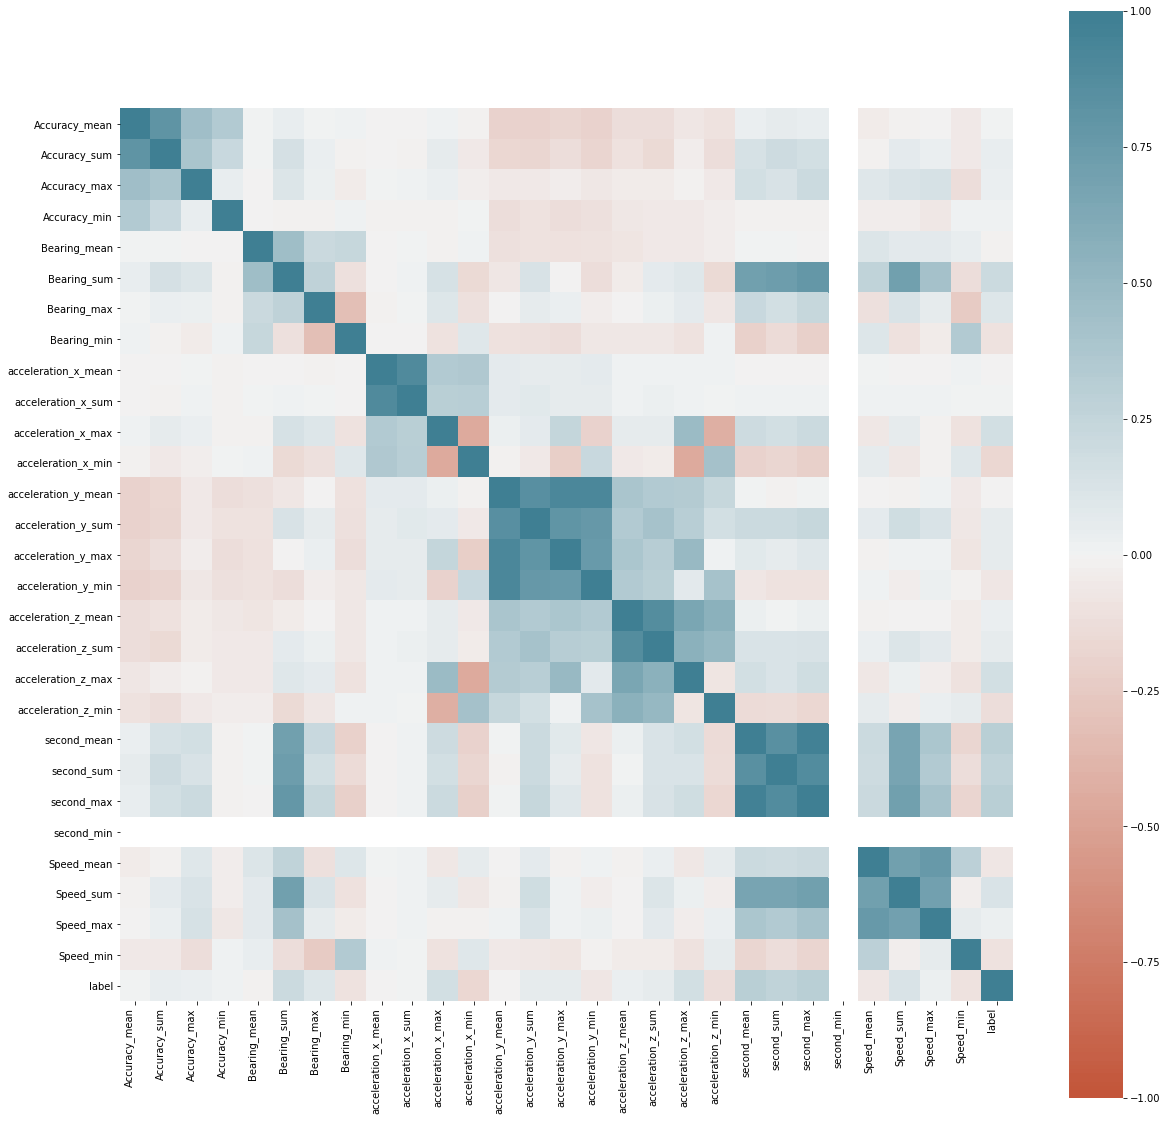

In [ ]:
# Computes the pairwise correlation between columns
corr=df.corr()

fig, ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(
   corr, 
   vmin=-1, vmax=1, center=0,
   cmap=sns.diverging_palette(20, 220, n=200),
   square=True
)
ax.set_xticklabels(
   ax.get_xticklabels(),
   horizontalalignment='right'
);

In [ ]:
# From the heatmap,it can be seen that 'second_min' have no relation toward 'label'
df.drop(columns=['second_min'],inplace=True)

In [ ]:
# Generation of more features - Velocity, Distance, Rotation angles
for col in df.columns:
    if col.startswith("second"):
        agg_method = col.split("_")[1]
        df["distance_" + agg_method] = df[col] * df["Speed_" + agg_method]
        df["velocity_x_" + agg_method] = df[col] * df["acceleration_x_" + agg_method]
        df["velocity_y_" + agg_method] = df[col] * df["acceleration_y_" + agg_method]
        df["velocity_z_" + agg_method] = df[col] * df["acceleration_z_" + agg_method]

# **Feature Selection**

In [ ]:
# Analyzing the columns
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16116622 entries, 0 to 16154417
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   bookingID       int64  
 1   Accuracy        float64
 2   Bearing         float64
 3   acceleration_x  float64
 4   acceleration_y  float64
 5   acceleration_z  float64
 6   gyro_x          float64
 7   gyro_y          float64
 8   gyro_z          float64
 9   second          float64
 10  Speed           float64
 11  label           int64  
dtypes: float64(10), int64(2)
memory usage: 2.2 GB


In [ ]:
corr=abs(df.corr()['label'].sort_values(ascending = False))
print(corr)

label                  1.000000
second_max             0.305921
second_mean            0.301935
velocity_x_max         0.268064
second_sum             0.263532
distance_max           0.251222
velocity_z_max         0.248577
Bearing_sum            0.196389
distance_sum           0.193159
velocity_y_max         0.185243
acceleration_x_max     0.168478
distance_mean          0.160825
acceleration_z_max     0.157124
Speed_sum              0.120908
Bearing_max            0.108110
velocity_z_mean        0.077702
velocity_y_mean        0.076470
velocity_y_sum         0.067450
acceleration_y_max     0.058698
acceleration_y_sum     0.051111
acceleration_z_sum     0.047503
Accuracy_sum           0.039917
velocity_z_sum         0.035265
acceleration_z_mean    0.033382
Accuracy_max           0.033188
Speed_max              0.030518
velocity_x_sum         0.011679
Accuracy_min           0.008024
acceleration_x_sum     0.007446
Accuracy_mean          0.006303
velocity_x_mean        0.005590
accelera

In [ ]:
# Lets drop the unnessary columns that have nor corr to the label
df.drop(columns=["Speed_min", "Bearing_min", "acceleration_z_min", "acceleration_x_min"], inplace=True)

# Model Selection


In [ ]:
X = df.drop(columns=["label"]).reset_index(drop=True)
y = df.label.reset_index(drop=True)
X = np.asarray(X)
y = np.asarray(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 3997
number of training samples: 15985


In [ ]:
# Training using Neural Network
model = tf.keras.models.Sequential([
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(12, activation='relu'),
    # Only 1 output neuron. 
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(x_train,y_train,epochs=100,validation_data=(x_test,y_test))
score = model.evaluate(x_test,y_test)
print("Accuracy: %.2f%%" % (score[1]*100))
print("Error: %.2f%%" % (100-score[1]*100))


Epoch 1/100
500/500 [==============================] - 1s 2ms/step - loss: 87480328.0000 - accuracy: 0.4602 - val_loss: 13997095.0000 - val_accuracy: 0.6387
Epoch 2/100
500/500 [==============================] - 1s 1ms/step - loss: 6640430.0000 - accuracy: 0.5218 - val_loss: 5595177.0000 - val_accuracy: 0.6457
Epoch 3/100
500/500 [==============================] - 1s 1ms/step - loss: 4954032.5000 - accuracy: 0.5414 - val_loss: 2822195.5000 - val_accuracy: 0.6187
Epoch 4/100
500/500 [==============================] - 1s 1ms/step - loss: 2790616.2500 - accuracy: 0.5556 - val_loss: 2826985.0000 - val_accuracy: 0.6890
Epoch 5/100
500/500 [==============================] - 1s 1ms/step - loss: 2798334.7500 - accuracy: 0.5480 - val_loss: 1914714.0000 - val_accuracy: 0.5314
Epoch 6/100
500/500 [==============================] - 1s 1ms/step - loss: 2660441.7500 - accuracy: 0.5581 - val_loss: 1612624.0000 - val_accuracy: 0.5669
Epoch 7/100
500/500 [==============================] - 1s 1ms/step -

In [ ]:
print("History Keys",history.history.keys())

History Keys dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


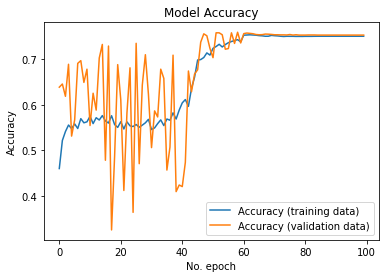

In [ ]:
import matplotlib.pyplot as plt


# Plot history: Accuracy
%matplotlib inline
# plt.ylim(0.6,1.05)
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

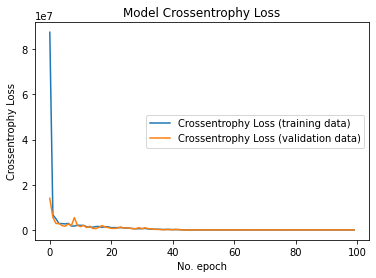

In [ ]:
# Plot history: loss
%matplotlib inline
# plt.ylim(-0.1,1.0)
plt.plot(history.history['loss'], label='Crossentrophy Loss (training data)')
plt.plot(history.history['val_loss'], label='Crossentrophy Loss (validation data)')
plt.title('Model Crossentrophy Loss')
plt.ylabel('Crossentrophy Loss')
plt.xlabel('No. epoch')
plt.legend(loc="center right")
plt.show()
